In [1]:
%load_ext autoreload
%autoreload 2

PianorollDataset initialized with 529062 segments from 8063 songs


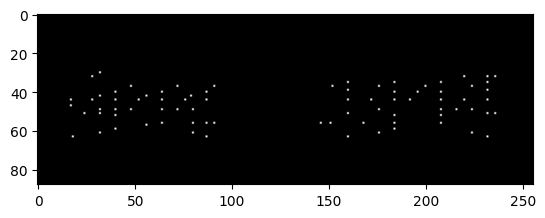

In [2]:
from pathlib import Path
from diff_music.data.dataset import PianorollDataset
from music_data_analysis import show_pianoroll
ds = PianorollDataset(Path('W:\\piano-ai\\pop80k'), frames_per_beat=8)
show_pianoroll(ds[10])

In [3]:
from diff_music.models.transformer import PianorollDenoiser
import torch
from torch import Tensor
from torch.utils.data import DataLoader

from diff_music.models.video_diff import VideoDiffusion

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# denoiser_params = PianorollDenoiser.Params(
#     dim=256,
#     max_length=256,
#     depth=3,
#     heads=8,
#     rotary_pos_emb=True,
#     time_conv_dilations=[1, 2, 4, 8, 16],
#     pitch_conv_dilations=[1, 2, 7, 12],
#     attn_type='linear',
# )
# denoiser = PianorollDenoiser(denoiser_params, 1).to(device)

denoiser_params = VideoDiffusion.Params(
    dim=768,
    max_length=32,
    depth=6,
    heads=8,
    rotary_pos_emb=True,
    frames_per_bar=32,
)
denoiser = VideoDiffusion(denoiser_params, 1).to(device)

total_params = sum(p.numel() for p in denoiser.parameters())
print(f"Total parameters: {total_params/1e6:.2f}M")

x = torch.randn(1, 1, 256, 88).to(device)
time_steps = torch.randint(0, 256, (1,)).to(device)
denoiser(x, time_steps).shape

Total parameters: 75.71M


c:\Users\User\miniconda3\envs\gr\Lib\site-packages\x_transformers\attend.py:395: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  out = F.scaled_dot_product_attention(


torch.Size([1, 1, 256, 88])

In [4]:
from diff_music.binary_diffusion import BinaryDiffusion
diff_params = BinaryDiffusion.Params(
    total_steps=64,
    loss_final='weighted',
    use_softmax=True,
    beta_type='cos',
    p_flip=False,
    aux=0,
    use_label=False,
    guidance=0.0,
    channels=1,
    focal_alpha=0.8,
    focal_gamma=5,
)
diff = BinaryDiffusion(diff_params, denoiser).to(device)

Noise scheduler with cos:
Diffusion 1.0 -> 0.5:
1.0000 0.9997 0.9988 0.9973 0.9952 0.9925 0.9892 0.9854 0.9810 0.9760 0.9705 0.9644 0.9579 0.9508 0.9433 0.9352 0.9268 0.9179 0.9086 0.8989 0.8889 0.8785 0.8678 0.8569 0.8457 0.8342 0.8226 0.8107 0.7988 0.7867 0.7745 0.7623 0.7500 0.7377 0.7255 0.7133 0.7012 0.6893 0.6774 0.6658 0.6543 0.6431 0.6322 0.6215 0.6111 0.6011 0.5914 0.5821 0.5732 0.5648 0.5567 0.5492 0.5421 0.5356 0.5295 0.5240 0.5190 0.5146 0.5108 0.5075 0.5048 0.5027 0.5012 0.5003 0.5000
Diffusion 0.0 -> 0.5:
0.0000 0.0003 0.0012 0.0027 0.0048 0.0075 0.0108 0.0146 0.0190 0.0240 0.0295 0.0356 0.0421 0.0492 0.0567 0.0648 0.0732 0.0821 0.0914 0.1011 0.1111 0.1215 0.1322 0.1431 0.1543 0.1658 0.1774 0.1893 0.2012 0.2133 0.2255 0.2377 0.2500 0.2623 0.2745 0.2867 0.2988 0.3107 0.3226 0.3342 0.3457 0.3569 0.3678 0.3785 0.3889 0.3989 0.4086 0.4179 0.4268 0.4352 0.4433 0.4508 0.4579 0.4644 0.4705 0.4760 0.4810 0.4854 0.4892 0.4925 0.4952 0.4973 0.4988 0.4997 0.5000
Beta:
1.0000 0.9994 

In [5]:
from dataclasses import dataclass


@dataclass
class TrainingParams:
    lr: float
    epochs: int
    batch_size: int
    generate_steps: int
    num_workers: int = 0

training_params = TrainingParams(
    lr=2e-4,
    epochs=1,
    batch_size=16,
    generate_steps=500,
    num_workers=6,
)


In [6]:
from datetime import datetime
import wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="vqpiano",
    group="binary-diffusion",
    id=datetime.now().strftime("%Y%m%d_%H%M%S"),
    # Track hyperparameters and run metadata
    config={
        "training": training_params,
        "denoiser": denoiser_params,
        "diffusion": diff_params,
    },
)

wandb: Currently logged in as: eri24816 (tanchihpin0517-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [7]:

from music_data_analysis import Pianoroll
from tqdm import tqdm
import einops

import torch_util
import torch_util.wandb

dataloader = DataLoader(ds, batch_size=training_params.batch_size, shuffle=True, num_workers=training_params.num_workers)

optim = torch.optim.Adam(diff.parameters(), lr=training_params.lr)


diff.train()

step = 0
for epoch in range(training_params.epochs):
    progress = tqdm(dataloader)
    for x in progress:
        x: torch.Tensor
        x = x.to(device).unsqueeze(1)
        
        loss, bce_loss = diff(x)['loss'], diff(x)['bce_loss']
        optim.zero_grad()
        loss.backward()
        optim.step()
        progress.set_postfix(loss=loss.item())

        wandb.log({
            'loss': loss.item(),
            'bce': bce_loss.item(),
        }, step=step)

        if (step < training_params.generate_steps*2 and step % (training_params.generate_steps//5) == 0)\
        or (step % training_params.generate_steps == 0):
            diff.eval()
            sampled = diff.sample((1, 1, 256, 88),return_all=True).detach().cpu()
            
            T = sampled.shape[1]
            num_display_steps = 4
            display_steps = [0] + list(reversed([T -1 - i * (T // num_display_steps) for i in range(num_display_steps)]))

            denoising_proc_img = einops.rearrange(sampled[:,display_steps].flip(4), 'b t c h w -> c (t w) (b h)')
            torch_util.wandb.log_image(denoising_proc_img, 'denoising', step)

            x0 = sampled[0,-1,0].flip(1)
            torch_util.wandb.log_image(einops.rearrange(x0, 't p -> p t'), 'x0', step)

            torch_util.wandb.log_image(einops.rearrange(x[0,0].flip(0), 't p -> p t'), 'x', step)

            pr = Pianoroll.from_tensor(x0, frames_per_beat=8, binary=True)
            torch_util.wandb.log_midi_as_audio(pr.to_midi(), 'audio', step)
            diff.train()

        step += 1

 56%|█████▌    | 18415/33067 [1:18:41<1:02:36,  3.90it/s, loss=0.000582]


KeyboardInterrupt: 

In [13]:
song = ds.ds.get_song('@Piano-X\\WjMsCD65VCw\\0_222')

song.read_json('duration') // 64

368

In [12]:
Pianoroll.from_midi(song.read_midi('synced_midi'))

Pianoroll Bar 000 - 090 of 

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

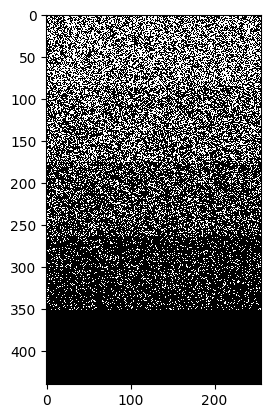

In [ ]:
import einops
import matplotlib.pyplot as plt
from music_data_analysis import Pianoroll
diff.eval()
with torch.no_grad():
    sampled = diff.sample((1, 1, 256, 88),return_all=True).detach().cpu()
T = sampled.shape[1]
num_display_steps = 4
display_steps = [0] + list(reversed([T -1 - i * (T // num_display_steps) for i in range(num_display_steps)]))

denoising_proc_img = einops.rearrange(sampled[:,display_steps].flip(3), 'b t c h w -> (t w) (b h) c')
plt.imshow(denoising_proc_img, cmap='gray', interpolation='none')

Pianoroll.from_tensor(sampled[0,-1,0], frames_per_beat=8, binary=True).to_midi('output.mid')

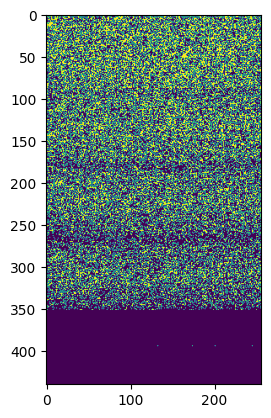

In [13]:
import matplotlib.pyplot as plt
plt.imshow(einops.rearrange(sampled[:,display_steps], 'b t c h w -> (t w) (b h) c'))

In [8]:
from music_data_analysis import Pianoroll
Pianoroll.from_tensor(ds[0], frames_per_beat=8, binary=True).to_midi('output.mid')

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

torch.cuda.empty_cache()

In [4]:
from diff_music.models.video_diff import VideoDiffusion


VideoDiffusion.Params(
    dim=256,
    max_length=256,
    depth=3,
    heads=8,
    rotary_pos_emb=True,
    frames_per_bar=32,
)

denoiser = VideoDiffusion(VideoDiffusion.Params(
    dim=256,
    max_length=256,
    depth=3,
    heads=8,
    rotary_pos_emb=True,
    frames_per_bar=32,

torch.Size([1, 256, 176])

In [63]:
x.shape

torch.Size([8, 256, 88])